In [ ]:
# ÖZET:
# Input gate : Cell state e bilgileri ilave etmek için kullanılır.
# Output gate: Bir sonraki hidden state imizi belirliyor cell state deki keyword bilgilerini hidden state e aktarıyorum, 
# .. cell state ve hidden state eşitleniyor ve tahminler hidden state üzerinden yapılıyor
# Forget gate:  in bir işlem yapabilmesi için cell state de bir bilgi olsun ki onu unutturmak için kullanılsın

# class chat: output gate bir kez mi çalışıyor
# Johnson H: Hayır. Output gate her "t" anında çalışır. Her t anından hidden state ve cell state güncellenmeye devam eder

In [ ]:
# Gated Recurrent Unit(GRU)-2014
# LSTM ile çalışma farklılıkları var
# GRU seri çalışır. Bu daha çok tercih edilir.
# Johson H: İkisini de deneyin hangisi daha iyi sonuç verirse onu kullanın. Tahminleme arasında fark yok

# LSTM de hidden state ve cell state in mekanizmaları aynı iken. GRU da tek bir mekanizma üzerinde birleşir
# reset gate  : Hem Hidden state ve hem de cell state gibi çalıştığı için sistem olduğundan keyword ümde olmayan bilgilerin hepsini birden siler
# update gate : Bir bilginin güncellenmesi veya 1 veya 2 tokenin unutturulmasını sağlar

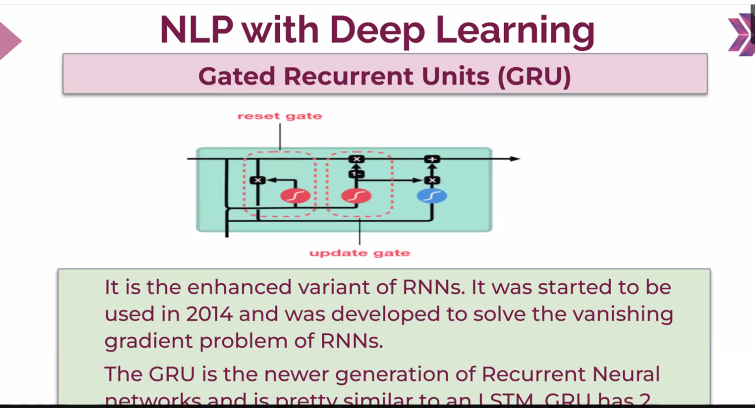

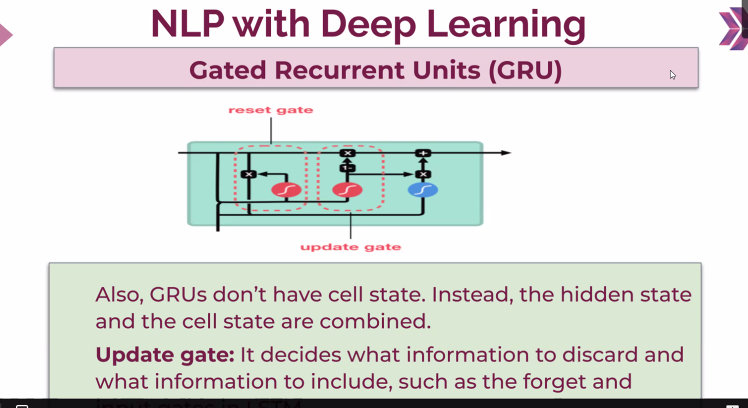

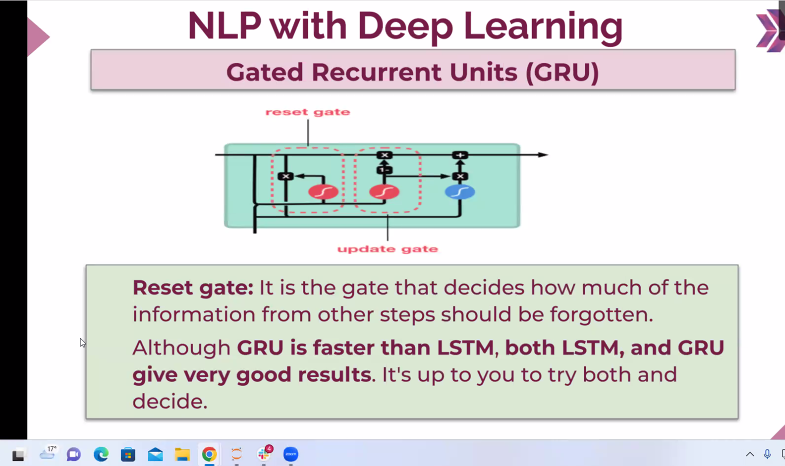

In [ ]:
 # Yemeğin hangi dünya mutfağına ait olduğunu bilen bir modelimiz var
 # Hafızasında 2 token tutabildiğini varsayalım Dhval ı modele verdik , sonra eats i verdik, sonra samosa gelince Dhaval gitti
 # .. bu şekilde devam ediyor en son da "cuisine" ve "is" kalıyor. Ancak modelin tahmin yapabilmesi için hafızasında "samosa" tokeni 
 # .. olması lazım ki "india" şeklinde tahmin edebilsin
 # RNN modelleri "samosayı unutmuş oldu ve tahmin yapamadı

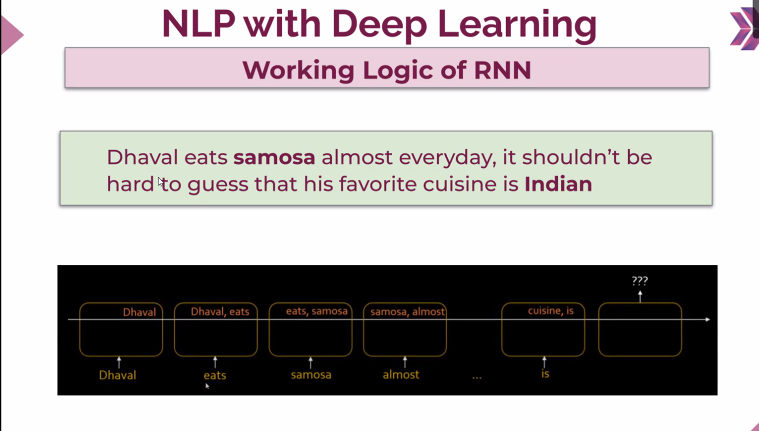

In [ ]:
# Dhaval verildi. Bu bir keyword değil dedi ve aktarılmadı cell state e
# Eats verildi  ....................... aktarılmadı
# samosa                      .....     aktarıldı
# hidden state tüm bilgileri tutarken cell state hafızasında sadece "samosa" bilgisini tutar ve tahmin olarak "indian" der model

# samosa geldi  ..... aktarıldı
# pasta geldi  .... samosa unutturuldu, pasta geldi
# .. en sonra pasta ve cheese üzerinden "Italian" olarak tahmin etti

# NOT: hidden state hafızasında 2 token tutabiliyorsa, cell state de 2 token tutar(Yani aynı sayıda)
# Hidden state ve cell state in max ne kadar tutabildiğini bilemeyiz net olarak. Burada örnek olması için "2 token tutabiliyor olsun" denildi

# Class chat soru : keywords leri nasıl belirliyor
# Johnson H : Keyword ler eğitim aşamasında belirleniyor

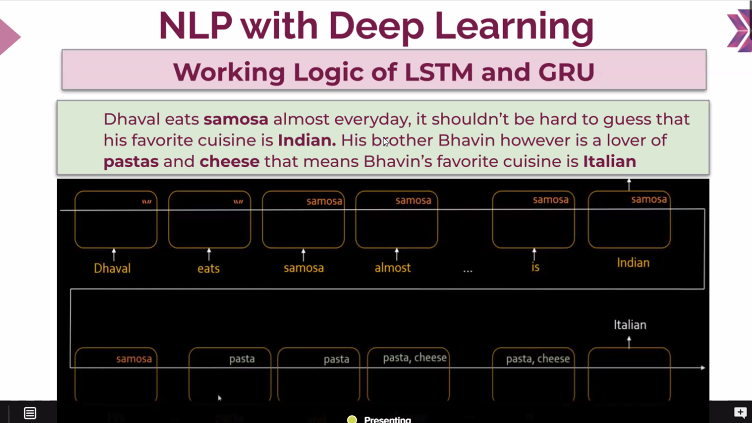

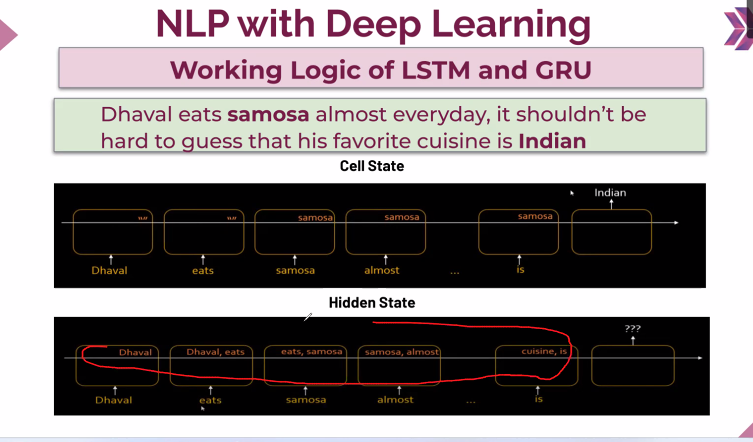

##### Hocam ne zaman GPU veya TPU kullanmak gerekli?
##### NOT: TPU , GPU nun daha hızlı halidir
##### TPU sadece tensorflow a çalışır

## NLP with DL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
df = pd.read_csv('/content/drive/MyDrive/hepsiburada.zip')

"""
import zipfile

# Unzip the file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ML_NLP/hepsiburada.zip", "r")
zip_ref.extractall()
zip_ref.close()
"""

'\nimport zipfile\n\n# Unzip the file\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/ML_NLP/hepsiburada.zip", "r")\nzip_ref.extractall()\nzip_ref.close()\n'

In [10]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [6]:
# 2. ders
# NOT: NLP de missing values lar doldurulmaz. Drop edilir. Boş bir text görürsek mutlaka silinir.
df.info()
# Olumlular 1, olumsuzlar 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243497 entries, 0 to 243496
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  243497 non-null  int64 
 1   Review  243497 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [ ]:
df.Rating = df.Rating.map({1:0, 0:1})
# hedefim benim negatifler olduğu için 1 leri 0 , 0 ları 1 yaparak mapledik
# Çünkü mesela ANN de sonuçlar gelirken(örneğin: recall, loss) bu sonuç "1" label ının sonucudur. O yüzden değiştirdik
# Hatırlatma: Datanın multiclass ise "recall" vs yerine "accuracy" de kullanılabilir çünkü çıktılar "micro" dur

In [ ]:
df.Rating.value_counts()

0    229821
1     13676
Name: Rating, dtype: int64

In [ ]:
df.Rating.value_counts(normalize=True)

0    0.943835
1    0.056165
Name: Rating, dtype: float64

## Tokenization

In [ ]:
X = df['Review']
y = df['Rating']

In [ ]:
num_words = 15000 # corpusta geçen en fazla kullanılan ilk 15.000 kelimeyi(tokeni) alacağız gerisini yok sayacağız. 
# None değeri atanırsa tüm kelimeler dikkate alınır.
tokenizer = Tokenizer(num_words=num_words) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890' 
# num_words=15000 : Textlerin sayısal forma dönüştürürken sadece datamda en sık kullanılan ilk 15000 tokeni dikkate al ve
# ..  eğitim yaparken ilk 15000 tokeni dikkate al ve dönüşümleri buna göre yap
# En uygunu bütün tokenlerin kullanılması ancak hesaplama maliyeti olacaktır. Makinanız güçlü değilse 10000 veya 15000 deneyin(best practice) 
# num_words= None --> None olursa bütün tokenleri kullan demek.
# Burada tokenlerine ayırırken küçük harfe dönüştürüyor, noktalama işaretlerini kaldırıyor
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'  : Eğer sayıları da temizlemek istiyorsak "Tokenizer" içine bunu yazabiliriz
# class chat soru: karşılaşmadığı kelimelere ne işlem uyguluyor?
# Johnson H : Onları ignore ediyor
# class chat soru: Burada oran şeklinde verebilir miyiz?
# Johnson H : num_words = the maximum number of words to keep, based on word frequency.
# .. dökümanında geçen açıklaması bir oran şeklinde belirtilmemiş. the max number of words ifdesi zaten integer sayıyı tarif ediyor hocam.

In [ ]:
tokenizer.fit_on_texts(X) # tokenizer işlemini X e uygulla

## Creating word index

In [ ]:
tokenizer.word_index # Datamda en sık kullanılan kelimeleri kullanım sıklıklarına göre sıraladı
# Datamda en sık kullanılan kelime "çok" muş.
# Text i sayısal forma dönüştürürken bu rakamları kullanacağım. Örneğin "bir" kelimesi sayısal olarak "2" ye dönüşecek

{'çok': 1,
 'bir': 2,
 've': 3,
 'ürün': 4,
 'bu': 5,
 'iyi': 6,
 'güzel': 7,
 'için': 8,
 'tavsiye': 9,
 'ederim': 10,
 'daha': 11,
 'ama': 12,
 'da': 13,
 'gayet': 14,
 'hızlı': 15,
 'teşekkürler': 16,
 'aldım': 17,
 'de': 18,
 'ürünü': 19,
 'gibi': 20,
 'yok': 21,
 'uygun': 22,
 'olarak': 23,
 'kaliteli': 24,
 'en': 25,
 '2': 26,
 'kargo': 27,
 'fiyat': 28,
 'elime': 29,
 'kadar': 30,
 'ile': 31,
 'göre': 32,
 'geldi': 33,
 'var': 34,
 'hepsiburada': 35,
 'ben': 36,
 'gerçekten': 37,
 '1': 38,
 'fiyata': 39,
 'gün': 40,
 'sonra': 41,
 'cok': 42,
 'kesinlikle': 43,
 'telefon': 44,
 'biraz': 45,
 'hiç': 46,
 'ulaştı': 47,
 'memnun': 48,
 'hem': 49,
 'değil': 50,
 'kullanışlı': 51,
 '3': 52,
 'mükemmel': 53,
 'oldu': 54,
 'kullanıyorum': 55,
 'önce': 56,
 'sipariş': 57,
 'tek': 58,
 'her': 59,
 'bence': 60,
 'harika': 61,
 'kalitesi': 62,
 'bi': 63,
 'ayrıca': 64,
 '5': 65,
 'teşekkür': 66,
 'fiyatı': 67,
 'olması': 68,
 'ne': 69,
 'herkese': 70,
 'bile': 71,
 'uzun': 72,
 'süper': 73,

In [ ]:
len(tokenizer.word_index) # Unique token sayısı
# num_words=15000 demiştik yukarda ama burada tokenizer uygulanan tokenlerin sayısı 217000
# Text imde geçenlerin hepsine token muamelesi yapar. ancak "tokenizer" değişkenimizin için eğitimi  hem dönüşümde
# .. ilk 15000 ini ile yapacağı bilgisi mevcut.

217983

## Converting tokens to numeric

In [ ]:
X_num_tokens = tokenizer.texts_to_sequences(X)
# texts_to_sequences : text i sayısal dizine dönüşyür
# Bütün yorumlarım sayısal forma dönüştü
# Kontrol yapalım altta

In [ ]:
X[105] # Bu yorumun sayısal hale dönmüş haline bakalım altta

'Logitech ürünlerinin geneli kalite olarak çok iyidir. Adedini tam saymadım ama 10 un üzerinde kendime akrabalarıma arkadaşlarıma almışımdır hepside memnunlar. İhtiyacı olan kaçırmasın başkada ürün aramasın derim.'

In [ ]:
print(X_num_tokens[105])
# Bakın 5. kelime "çok" du. Bu "1" e dönüşmüş. Çünkü üstte "çok" un karşısında 1 vardı
# Ancak üstte "çok" üstteki text te 6. sırada ama alttaki çıktıda "1" numarası 5. sırada. çünkü
# .. üstteki textte ilk 6 kelimeden(Logitech ürünlerinin geneli kalite olarak çok) 1 tanesi datamda en çok kullanılan 15000 kelimeden biri değilmiş

# DL modellerimiz, ML modellerimizde olduğu gibi datanın aynı boyutta olmasını ister. Bunların boyutlarını sabit aynı boyuta getirmeliyiz
# .. ancak bu boyut sayısını nasıl belirleyeceğiz ona bakalım

# class chat soru:  niye stopwords  yapmadık  hocam? ilk 15000 de bu kelimeler çokça geçiyor
# Johnson H : SAdece ML de stopwords çıkarılıyor. DL de stopwords ler çıkarılmaz

[1816, 5360, 131, 23, 1, 1849, 74, 12, 118, 1533, 297, 745, 3216, 13402, 6326, 5030, 2463, 113, 2534, 8858, 4, 143]


## Maximum number of tokens for all documents

In [ ]:
len(X_num_tokens[105]) # 105. yorum 22 tokenden oluşuyor

22

In [ ]:
len(X_num_tokens[106])

18

In [ ]:
len(X_num_tokens[6150])

88

In [ ]:
num_tokens = [len(tokens) for tokens in X_num_tokens]
num_tokens = np.array(num_tokens)
# nümeriğe dönüştürdüğüm yorumlar içerisindeki her bir yorumda gezip en sonra bunu array e dönüştüreceğiz

In [ ]:
num_tokens # 1. yorumum 4 tokenden oluşuyor ... 3. yorumum 66 tokenden oluşuyor ...

array([ 4,  4, 66, ...,  4, 10, 38])

In [ ]:
num_tokens.mean()  # Ortalama 21 tokenden oluşuyor yorumlar

21.36101060793357

In [ ]:
num_tokens.max()  # Bütün yorumlarımı 298 e sabitlersem hiç bir farkı olmaz. Eğer daha az sayı verirsek, mesela 100
# .. 298 tokenden oluşan bir yorumdan 198 tane token kırpılacak
# .. O yüzden en uzun olan token sayısına sabitlersem yorumlarımı bilgi kaybımız olmaz
# .. Peki sayıyı nasıl belirleyeceğiz eğer bazı yorumlarda bilgi kaybı olacaksa...

298

In [ ]:
num_tokens.argmax() # listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

21941

In [ ]:
X[21941] # En uzun yorumum bu

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

In [ ]:
len(X_num_tokens[21941])
# Burada yapmamız gereken işlem ne altta örnekle anlatalım

298

In [ ]:
list = [5, 10, 8, 9, 12, 15]  # 6 yorumum var. 1. yorumum 5 tokenden oluşuyor .... 6. yorumum 15 tokenden oluşuyor olsun
print(np.array(list) < 11)    # Bütün yorumlarımı 11 tokene sabitlersem. 5. yorumumda 1 token, 6. yorumumda 4 yoken kırpılacak(O yüzden onlar "False" geldi çıktıda)
print(sum(np.array(list) < 11)) # True ları topladı # Corpusunda 6 yorum var. Eğer bunları 11 tokene sabitlersen 4 tanesinde bilgi kaybı olmayacak anlamına geliyor
print(sum(np.array(list) < 11)/len(list)) # Bulduğum 4 sayısını datamdaki tüm yorum sayısına oranlıyoruz 4/6. Yani corpusumun %67 sinde bilgi kaybı olmayacak
# Biz bu oranın %95 olmasını istiyoruz. %5 lik kısmında bilgi kaybı olmasını göze alacağız(Çalışma maliyetinden kısmak için)

# Şimdi bu işlemin aynısını datamıza uygulayalım altta

[ True  True  True  True False False]
4
0.6666666666666666


In [ ]:
max_tokens = 61  # Bunu kendimiz belirliyoruz deneme yanılma ile

In [ ]:
sum(num_tokens < max_tokens) / len(num_tokens)
# Bütün yorumlarımı 61 tokene sabitlersem datamın %96 sında bilgi kaybı olmayacak. %4 hatam olabilir ama bu hatayı çalışma maliyetini azaltmak için göze alıyoruz

0.9598968365113328

In [ ]:
sum(num_tokens < max_tokens)

233732

In [ ]:
len(num_tokens)

243497

## Fixing token counts of all documents (pad_sequences)

In [ ]:
# Şimdi yorumlarımızın hepsini aynı boyuta getirelim

In [ ]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)
# pad_sequences : doldurma işlemi
# Datamdaki textlerimizi tek bir forma sabitleme işlemi yapıyoruz
# maxlen=max_tokens: Hangi boyuta sabitlemek istiyorsak

In [ ]:
X_pad.shape

(243497, 61)

In [ ]:
np.array(X_num_tokens[800]) # Orjinal hali(61 den kısa bir yorum)

array([  19,  341,   52,  194,   30,   54, 7992,   55,  209,  603, 7887,
          3,   36,  114,  164,  479,   85,    1, 1682,  782,   30,    2,
        380,  326,    3,    1,   81,  132,  562,    9,   10])

In [ ]:
len(np.array(X_num_tokens[800]))

31

In [ ]:
X_pad[800] # padding işlemi uygulanmış hali
# Başına 30 tane 0 ilave etti başa(Doldurma işlemi yaptı)
# class chat: token sayısı max dan az olanları da 0 ile tamamlıyor
# Johnson H: Aynen

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   19,  341,   52,
        194,   30,   54, 7992,   55,  209,  603, 7887,    3,   36,  114,
        164,  479,   85,    1, 1682,  782,   30,    2,  380,  326,    3,
          1,   81,  132,  562,    9,   10], dtype=int32)

In [ ]:
np.array(X_num_tokens[21941]) # Orjinal hali(61 den uzun bir yorum)

array([  145,     5,  5876,  2225,  1653,   902,   203,     1,     6,
        2958,   163,  4248,   374,  3449,  1521, 12582,     3,  1381,
           1,   491,   281,   140,     1,   491,  3391,  2388,   235,
          21,    82,   756,    31,   212,  4458,  1448,    14,     6,
         472,   609,  2159,    14,    15,   673,  1681,  2152,     3,
         313,   444,   261,    13,   561,   463,   470,  1664,   168,
         639,   519,  3209,  5455,  6409,   600,   625,   153,    38,
         194,   272,   635,   389,   140,    26,    52,    40,   272,
          15,    84,    38,   466,  1679, 12350,  1036,   999,     3,
          96,     2,   318,    34,   134,   169,    40,  2752,     3,
          77,   750,   168,   881,     3,   509,   571,   359,   195,
           1,   491,     3,   172,    82,   256,  6460,    45,   926,
         195,  2061,  6575,   603,  7031,   235,    21,   103,   931,
         136,   394,  1316,  1917,     5,  2167,   567,  1034,  2217,
          26,   335,

In [ ]:
X_pad[21941] # Cümlede ana fikir genelde cümle sonunda olduğu için sondaki 61 tanesini alıyor pad_sequence

array([ 872, 3501,  537, 1804,  488, 2218,   75,  163,    2,  456,   13,
       1308, 1865, 3432,    5,  824, 7798,  836, 1640, 7838, 3344,   12,
       1308,   31, 3063,  299, 2704,  851, 1052,   39, 1490, 3436,  317,
       1170,   75,  537,   50,  327,  246, 1322,  120,    2, 3436, 7527,
        199,  260,  579, 6176, 1800,   13,   45,  808,  108,    3,  865,
        749, 5840,   50,  106,   76,  879], dtype=int32)

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=0)

## Modelling

In [ ]:
model = Sequential()  # Ben bir DL modeli oluşturuyorum demek. Sıralı(sequential) şekilde layerlarımı oluşturabilirim demek

In [ ]:
embedding_size = 50

In [ ]:

model.add(Embedding(input_dim=num_words,         # 15000 .Giriş boyutu.input_dim: Eğitim de datamda en fazla geçen ilk 15000 tokeni kullan 
                    output_dim=embedding_size,   # 50    .Çıkış boyutu. embedding_size : Dönüştüreceğim word_embeddingler kaç boyutlu olsun
                    input_length=max_tokens))    # 61    .Dataya girecek olan inputumub uzunluğu. Kendisine verilecek olan her bir yorumların kaç boyutlu olacağı

model.add(Dropout(0.2))                         # 50 boyutlu word embbedingler GRU ya aktarılırken 0.2(maximum %20) si sönümlenecek # Not: Nöronlara uygulanan sönümlendirme maximum %20 dir. Her zaman %20 uygulamaz

# 3. ders
model.add(GRU(units=48, return_sequences=True)) # Boyutu 50 ile geldi, nöron sayısını 48 e düşürdük. # Bazı makalelerde "units=48", yeni "word embedding boyutu" olarak da geçer. 2 side doğrudur 
# return_sequences=True: Bunu True yapmazsanız modelleriniz çalışmaz. Çünkü t0 anındaki hidden state im "what" t1 de "what time"
# ..... t4 anında "what time is it ?" . Burada "is" ve "it" i de keyword olarak düşünelim(What ve time önceden keyword dü)
# .. Eğer cell state de çok fazla keyword birikirse cell state de de unutma durumu oluşabiliyor. Bir sonraki lstm layer ına 
# .. cell state deki bilgileri aktarırken(Aslında hidden state ler aktarılıyor çünkü hidden state ve cell state ler eşitleniyordu)
# ..  t4 anındaki bilgileri gönderirken ilk olanlar(What ve time) unutulabilir. return_sequences, her t anındaki
# .. hidden state leri diğer layer a gönderiyor. Yani eğer olurda son t anındaki hidden state bilgilerini unutursa onlara önceki layer lara bakıp hatırlayabiliyor
# .. sonraki layer "dense layer" olana kadar return_sequences=True yapıyoruz. Dense de son t anındaki hidden state aktarılıyor.(Dense layer da geriye dönemiyor. Orada unutma mecburen olacak)
model.add(Dropout(0.2))

model.add(GRU(units=24, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=12))

model.add(Dense(1, activation='sigmoid'))

# class chat: batch normalization burda var mı hocam önerir misiniz
# Johnson H: Deneyip göreceksiniz. Ben denedim ama iyi sonuç gelmedi. Genelde batch normalization daha iyi sonuç veriyor
# class chat : input_length farklı gelirse ignore ediyor?
# Johnson H : Hata alırsınız(Mesela 61 yerine 62 dersek hata alırız)
# class chat soru : embedding size ı neye göre belirledik hocam
# Johnson H: 50, 100, 300 best practice dir. Özellikle NLP algoritmalarında model çok kolay overfit e gidebiliyor. 
# .. Bunu engellemek için dropout oranlarıyla oynanabilir(0.5 e kadar(best practice) deneyebilirsiniz), batch normalization
# .. gibi metodlar var. Diğer bir yöntem de embedding_size dır. Bu embbedding_size ı büyültüp küçülterek deneyin mutlaka
# .. Diğer bir yöntem layer sayısını azaltmak. Zaten genelde layer sayısı 5 i geçmez yani tavsiye edilmez. Overfit e giderseniz layer sayısını azaltın
# .. Diğer bir yöntem learning rate ile oynamaktı(Altta ayarlayacağız)
# .. Diğer yöntemler early stop, batch_size la oynamak,  sample_weight= classes_weights ..(Bunların altta açıklaması var)
# class chat soru: o zaman biraz daha deneme yanilma seklinde olacak bu sayi hocam degil mi
# Johnson H: Aynen hocam
# class chat soru : Hocam burada hangi word embedding metodunu kullanacağını da belirtebiliyor muyuz?
# Johson H : Bu zaten DL modellerinde kullandığımız kendine has bir metoddur. Burada word2vec vs gibi bir şey kullanmıyoruz


# NOT: word embedding de  ilk değerler random olarak atanır

# XXXX
# NOT: input_dim=num_words : Burada num_words ü bir değişkene atamanız lazım yoksa burada integer yazarsanız hata alırsınız
# .. num_words ü de tanımlarken integer bir sayı girmeniz gerekiyor(input_length=max_tokens için aynı şey geçerli)
# class chat soru: input_dim=num_words : Hocam burada input lar yorumlar mı tokenler mi? 
# Johnson H : Tokenler. İlk 15000 token
# class chat soru: küçük datalarda bütün tokenleri kullan diyebilir miyiz modele
# Johnson H: Onda daha iyi sonuçlar alırsınız ama bazı durumlarda bilgisayarınız kuvvetli değilse bunu uygulayamazsınız
# NOT: # butün data yı kullanıyorsak token sayısı --> num_words = len(tokenizer.index_word)

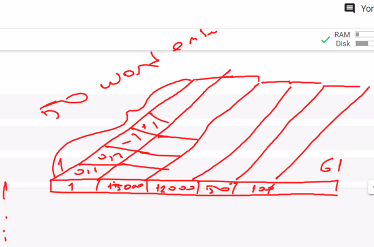

In [ ]:
optimizer = Adam(learning_rate=0.008) 

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, # optimizer : DL arka planda hangi gradient descent algoritmasını kullansın --> Adam
              metrics=['Recall'])

# binary_crossentropy: Bunun(loss un) 0 olması demek neyi ifade ediyor? 
# .. Bir yorumu %100 olasılıkla tahmin etmişsem log(1) = 0(loss)  
# .. loss=0.001 Modeliniz o kadar iyi bir tahmin yapıyor ki 1 class ını ve 0 class ını neredeyse %100 iyi tahmin yapıyor(Örnek: log(0.996)=0.001 gibi... )

https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

In [ ]:
model.summary() 
# https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network
# Üsteki makalede alttaki formül var

# embedding_size * num_words ==> 50 * 15000 --->  embedding_11 (Embedding)    (None, 61, 50)            750000   

# 3 x (n2 + nm + 2n) m= input, n= output
# (48*48 + 50*48 + 2*48)*3 ==> m = 50(embedding_size), n = 48(GRU dan kaç boyutlu çıkacak)
# (24*24 + 48*24 + 2*24)*3 ==> m = 48, n = 24
# (12*12 + 24*12 + 2*12)*3 ==> m = 24, n = 12
# 12*1 + 1

# Total params: 771,109 : Datam 771,109 katsayıyla işlem görmüş

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 61, 50)            750000    
                                                                 
 dropout_32 (Dropout)        (None, 61, 50)            0         
                                                                 
 gru_32 (GRU)                (None, 61, 48)            14400     
                                                                 
 dropout_33 (Dropout)        (None, 61, 48)            0         
                                                                 
 gru_33 (GRU)                (None, 61, 24)            5328      
                                                                 
 dropout_34 (Dropout)        (None, 61, 24)            0         
                                                                 
 gru_34 (GRU)                (None, 12)              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max", 
                           verbose=1, patience = 1, restore_best_weights=True)
# overfit e gitmesini engellemek için early_stop u kullanıyorduk
# mode a asla "auto" yazmayın. Eğer auto yazarsak trende bakar(düşme eğiliminde mi artma eğiliminde mi). val_recall: 0.9053, val_recall: 0.8464 görür ve
# .. der ki val_recall düşmesi gereken bir şey olarak algılar. Halbuki recall değerini arttırmak isteriz 

# Johnson H: NLP de genelde 1-2 epoch da eğitimi bitirmemiz lazım çok çabuk overfit e gidiyor
# restore_best_weights=True : Bunu kullanmazsanız. Patience da eğitimi en son epochdaki katsayılar üzerinden metrikleri/skorları alır
# .. en iyi skoru aldığımız epoch a dönmez . en iyi skoru aldığımız epoch a dönmesi için restore_best_weights=True yapıyoruz

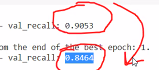

In [ ]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pd.Series(classes_weights).unique()

# Datada imbalance lık durumu olduğu için compute_sample_weigh(sample weight i ayarla). Neye göre class_weight='balanced'(Hepsi dengeli olacak)şekilde

array([0.52975426, 8.90215702])

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=256, sample_weight= classes_weights,
         validation_data=(X_test, y_test), callbacks=[early_stop])

# Overfitting varsa batch_size ile oynayacaktık. batch_size ın küçük olması eğitimimizin daha iyi olmasını sağlar çoğunlukla. İlk olarak overfitting varsa
# .. batch size ı "büyüterek" kontrol edin
# sample_weight= classes_weights : Bu az olan sınıfın skorlarını iyileştirdiği gibi, overfit i de önler . 

# XXXX
# Test skorları neden train skorlarından yüksek? İlk epochlar olması nedeniyle böyle olur.

Epoch 1/10
761/761 [==============================] - 17s 16ms/step - loss: 0.3195 - recall: 0.8582 - val_loss: 0.2823 - val_recall: 0.9053
Epoch 2/10
761/761 [==============================] - 11s 14ms/step - loss: 0.1939 - recall: 0.9300 - val_loss: 0.1987 - val_recall: 0.8464
Epoch 2: early stopping


## Model evaluation

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,0.319535,0.858240,0.282284,0.905302
1,0.193916,0.929988,0.198732,0.846435


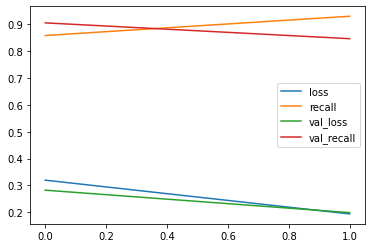

In [ ]:
model_loss.plot()
# loss değerleri birbirine yaklaşırken recal değerleri birbirinden uzaklaşıyor
# DL de eğer imbalance drumu varsa "loss" değerlerine bakmayınız
# Çünkü %96 olumlu yorum, %4 ü olumsuz yorum. Olumluları %100 tahmin edip, olumsuzları %40, %70, %61 gelecek ve ben bunların ortalamasını alsak
# .. % 57 gelir yani aslında olumsuzları çok yanlış tahmin yapıyor. Böyle olunca loss a bakmak bizim yanlış yorum yapmamıza sebep olur
# .. Sonuç olarak NLP de data imbalance ise loss a göre yorum yapmayacağız
# recalllar birbirinden uzaklaştığı için bu data overfite doğru gidiyor demek
# ML de accuracy ye bakmayın inbalance ise, DL de imbalance varsa loss a bakmayın
# DL de cross validation yoktur. Çünkü her iterasyonda katsayılar farklı yerlerden rasgele atanır ve alınan errorlar farklı farklı olur(farklı local minimumlara takıldıkları için)
# .. batch_size larımız her epoch da data içinde karışır. Evet cross validation yapılıyor ama katsayılar sabitlenip yapılıyor ama DL de katsayıların sabitlenmesi gibi
# .. bir durum yok. O yüzden DL de yaptığınız cross validation sağlıklı sonuçlar vermez

# class chat soru: hocam imbalanced datalarda loss'a bakmayalım dedik ama biz bu imbalance'lığı class_weights ile gidermiş olmadık mı ?
# Johnson H : Datamda 0 olumlu, 1 olumsuz olsun , birinde 100 tane olsun data, birinde 1000 tane olsun data. Datada dengeleme işlemi yapmazsam
# .. 100 tane çekersem aralarından 90 ı olumsuz, 10 u olumlu gelir ve sonra olumsuz sınıfa atayım gibi bir yorum yaparız. Yani fazla olan sınıfa yapılan
# .. tahminler daha yüksek olur. Biz balance ı yaparak az olan sınıfa daha fazla tahmin yaptırmış oluyoruz. Yani sonuç olarak az olan sınıfa yapılan tahmin sayısı arttırılıyor
# .. ancak bu loss değerlerini etkileyen bir durum değil. Etkiliyor ama çok kayda değer bir düşüş olmuyor loss da

In [ ]:
model.evaluate(X_test, y_test)
# Loss: [0.2822844684123993,
# recall :  0.9053016304969788]

1522/1522 [==============================] - 9s 6ms/step - loss: 0.2823 - recall: 0.9053


[0.2822844684123993, 0.9053016304969788]

In [ ]:
model.evaluate(X_train, y_train)
# Loss: [0.25349363684654236,
# recall :  0.9552143216133118] # Bu 4. , 5. epoch da 1 e gelirdi(overfit e giderdi)

6088/6088 [==============================] - 37s 6ms/step - loss: 0.2535 - recall: 0.9552


[0.25349363684654236, 0.9552143216133118]

In [ ]:
# 19.10.2022 DERS SONU

In [ ]:
# 20.10.2022
# Tekrar yapıldı. Söylenen yerleri yukarıya "XXXX" anahtar kelimesiyle aratarak bulabilirsiniz

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

y_pred = model.predict(X_test) >= 0.5  # 1 class ına ait olma olasılıklarını döndürür. Bu oranlar 0.5 den büyükse True ya döndür yoksa false a döndür

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))
# classification_report da true lar 1 olur, false lar 0 olur

# 0 sınıfında  : 0       0.99      0.89      0.94     45965
# .. skorlarımızda kötüleşme var(Ağırlıklandırma yaptığımız için,  Yani tahmin etme olasılıkları düştüğü için , 
# .. 1 class ına yapılan tahmin sayısını arttır ki o skorları daha iyi yakalayabilelim dediğimiz için oldu

# 1       0.33      0.91      0.49      2735 : Bu skorlar(recall yüksek ama precision ın kötü olması) normal. 
# .. İLerde BERT göreceğiz ve neden BERT modellerin tercih edildiğini göreceğiz

1522/1522 [==============================] - 8s 5ms/step
[[40993  4972]
 [  259  2476]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     45965
           1       0.33      0.91      0.49      2735

    accuracy                           0.89     48700
   macro avg       0.66      0.90      0.71     48700
weighted avg       0.96      0.89      0.91     48700



In [ ]:
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

#  Test:  1       0.33      0.91      0.49      2735
#  Train: 1        0.37      0.96      0.53     10941
# Overfit yok
# Üstte btün her şeyi yaptınız overfit'i engellemek için eğer hala overfit varsa epoch=1 e göre eğitim yapacaksınız
# .. ve parametrelerle tekrar  oynayacaksınız
# class chat soru: test_size 'ı düşürmek deep learning modellerinde de işe yarar mı hocam
# Johnson H: Evet. test size la da oynamalısınız overfit varsa düşürebiliriz. Önce 0.2 deneyip sonra 0.1 lere kadar düşürebiliriz
# .. BERT de böyle olmayacak. Train datasında, test datasında olsun olmasın bütün datalar dikkate alınıyor
# Recall güzel ama precision istediğim oranlarda değil
# 0.33      0.91      0.49      2735 modelim fazladan 3 kat fazla tahminde bulunmuş(8100 yorum)
# precision 0.33, recall 0.91 demek ; 2735 in yüzde 91 inı yakalamış ama fazladan 5400 küsür fazladan yorum yapmış demek

6088/6088 [==============================] - 28s 5ms/step
[[165724  18132]
 [   490  10451]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    183856
           1       0.37      0.96      0.53     10941

    accuracy                           0.90    194797
   macro avg       0.68      0.93      0.74    194797
weighted avg       0.96      0.90      0.92    194797



1522/1522 [==============================] - 8s 5ms/step


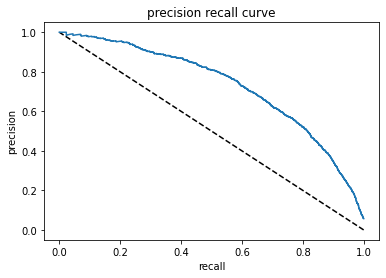

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test) # Burada dönen skor 1 label ının probasıdır.(1 sınıfına ait olma olasılıklarını döndürür)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

# predict_proba dediğimiz zaman 0 ve 1 in olasılıklarını döndürüyordu. O zaman y_pred_proba[:1] yazıyorduk 1 sınıfına ait olma olasılıklarını görmek için

In [ ]:
average_precision_score(y_test, y_pred_proba)
# Benim modelim nefgatif classları ayırma anlamında %73 başarılıymış

0.7293966913741898

## Scores without sample_weight

Test set

                precision    recall  f1-score   support

           0       0.98      0.99      0.98     45965
           1       0.72      0.63      0.67      2735

    accuracy                           0.97     48700
   
 
 
 
 Train set 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    183856
           1       0.87      0.80      0.84     10941

    accuracy                           0.98    194797
   

## Model Saving

In [ ]:
#model.save('review_hepsiburada.h5')

# class chat soru: Kaydederken dosya yolunu drive olarak versek doğrudan oraya kayıt yapmaz mı? Drive'a zaten bağlıyoruz
# class chat cevap: Yapıyor. Hızlı bir şekilde sorunsuz

##Loading Model

In [ ]:
#from tensorflow.keras.models import load_model
#model_review = load_model('/content/drive/MyDrive/review_hepsiburada.h5')

In [ ]:
# class chat soru: NLP'de model başarısı olarak yüzde kaç iyidir? Dataya göre yine değişir mi?
# Johnson H : Değişir hocam. Her zaman 80 li 90 lı skorlar almayı beklemeyin
# .. BERT model her türlü şeyi yakalıyor diyoruz ama farklı bir cümle gelince model şaşırabilir o cümle olumlu mu olumsuz mu
# .. Örnek cümle: Anyayı Konyayı görürsünüz telefonu alınca... gibi

## Predicton

In [ ]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım."
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "üründe sıkıntı var"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik."
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün.Teşekkürler '
review15 = 'telefon kesinlikle bu parayı hak etmiyor. yeni hiç bir özelliği yok. ancak küçük ekran sevenler için iyi bir telefon'
review16 = 'müthiş bir telefon ama bu parayı hak etmiyor'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16]
# Modelleri eğitime verirken tokenizer kullanmıştık. 

In [ ]:
tokens = tokenizer.texts_to_sequences(reviews) # Corpusumda geçen ilk 15000 tokene göre dönüşüm yaptırıyor
# Üstte geçen cümlelerdeki kelimeler(tokenler) ilk 15000 içinde değilse onlar ignore edilecek
# Johnson H: Ben tüm data ile de sonuçlar aldım ama skorlarda çok bir değişiklik olmadı. İsterseniz deneyebilirsiniz
# tokenizer.texts_to_sequences(reviews) : Yorumları en sık kullanılana ilk 15000 tokeni dikkate alarak nümeriğe dönüştür

In [ ]:
tokens
# [1, 146, 70, 9, 10] : Üstteki 1. cümle (review1)
# [73, 4] : Üstteki 2. cümle (review2)
# ...

[[1, 146, 70, 9, 10],
 [73, 4],
 [104, 2, 1032, 2333, 1466, 5, 19, 5, 1779, 11413],
 [4212, 11835],
 [553, 61, 82, 27, 1, 458, 33, 3, 4, 1032, 2333, 37],
 [46, 1096, 6419, 20, 50],
 [177, 735, 7728, 82, 263, 105, 326],
 [46, 5, 30, 177, 2, 1717, 1244, 4, 1723, 4600, 83],
 [74, 2, 28, 111, 19],
 [637, 20, 857],
 [395, 179, 1001, 511],
 [447, 147, 34],
 [7070, 318, 62, 1, 177, 375, 473, 286, 6559, 1412, 41, 9636, 774],
 [38,
  40,
  20,
  108,
  2,
  161,
  29,
  150,
  3,
  5,
  2855,
  73,
  2,
  4,
  9,
  10,
  1159,
  2430,
  104,
  113,
  2068,
  11,
  104,
  1150,
  175,
  12730,
  4,
  16],
 [44,
  43,
  5,
  1248,
  492,
  741,
  135,
  46,
  2,
  235,
  21,
  82,
  116,
  168,
  1598,
  8,
  6,
  2,
  44],
 [584, 2, 44, 12, 5, 1248, 492, 741]]

In [ ]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
tokens_pad.shape
# 16 yorumun her birini 61 e sabitledi

(16, 61)

In [ ]:
prob = model.predict(tokens_pad)
prob
# modelim eğitildi artık ve her bir tokenin word embeddingleri belirlendi. Predict yapıyoruz
# Bu oranlara göre, bunları 0.5 den büyük olanlar TRUE olacak. Küçükler False

1/1 [==============================] - 0s 28ms/step


array([[0.00668328],
       [0.02561737],
       [0.99520314],
       [0.13199313],
       [0.98342943],
       [0.9934284 ],
       [0.7113918 ],
       [0.97965586],
       [0.19007872],
       [0.99339104],
       [0.0114853 ],
       [0.806988  ],
       [0.98268616],
       [0.15148166],
       [0.964095  ],
       [0.9783675 ]], dtype=float32)

In [ ]:
pred = (model.predict(tokens_pad) >0.5).astype("int")
pred
# Truelar -->1 , false lar 0 oldu

1/1 [==============================] - 0s 24ms/step


array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [ ]:
pd.set_option('display.max_colwidth', None)
my_dict = {"Review":reviews, "prob":[i[0] for i in prob], "classes":[i[0] for i in pred]}
pd.DataFrame(my_dict)
# Yorumlarım tek boyutlu iken problarım ve class larım 2 boyutlu. Ya hepsi tek boyutlu olacak ya hepsi 2 boyutlu 
# Hepsi aynı boyutlu olsun diye ""[i[0] for i in prob]"  ve "[i[0] for i in pred]" yapıyoruz ve tek
# .. boyuta dönmüş oluyor.
# Bunuda en son df e dönüştürdürünce;
# Yorumları olasılıkları ve class predictionlarını görüyoruz
# pd.set_option('display.max_colwidth', None): df i n hücre genişliğini en uzun yoruma göre ayarla(O yüzden Review sütunu
# .. en geniş haline gelmiş ancak 12. ve 13. yorumda 2. satıra geçme olmuş. 2. satırda da son kelime satırın son kısmına 
# .. gelecek şekilde yazılmış/ayarlanmış)

# class chat not : 1 eklemeyince hata veriyor bütün tokenleri kullandığımız durumda böyle bi çözüm buldum
# .. https://keras.io/api/layers/core_layers/embedding/
# Johnson H: num_words ataması yaparken 1 artırarak kaydederseniz sorun olmaz. imput_dim = num_wordse eşit olmak zorunda

# 2. ders
# Olumlu yorumlarım --> 0, olumsuz yorumlarım --> 1 ... prob:0.006683: 1 class ına ait olma olasılığı
# 4. indexte tasarımı harika demesine rağmen "hayal kırıklığı" nın ağırlığının yüksek olduğuna kanaat getirmiş model
# .. ve olumsuz olarak(1 olarak) tahmin etmiş.
# 6. indexte bunun olumlu yorum olmasını bekleriz ama bilemedi neden? Ağırlıklandırma yaparken olumlu yorumları yakalayamasamda
# .. olur dedik o yüzden bilememiş yani olumsuzları tahmin etmeye daha çok odaklan demiştik.
# 14. indexte "bu parayı hak etmiyor" görünce model diğer hiç bir şeyi dikkate almamış. Alttaki kod a bkz

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.006683,0
1,süper ürün,0.025617,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.995203,1
3,kelimelerle tarif edilemez,0.131993,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.983429,1
5,hiç resimde gösterildiği gibi değil,0.993428,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım.,0.711392,1
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.979656,1
8,tam bir fiyat performans ürünü,0.190079,0
9,beklediğim gibi çıkmadı,0.993391,1


In [ ]:
count=0
for i, j in enumerate(X):
  if "hak etmiyor" in j.lower() and y[i]==1:
    count+=1
count

# "hak etmiyor" olumlu yorumlarda 1 defa, olumsuz yorumlarda 31 defa geçiyor. O yüzden "hak etmiyor"
# .. görünce olumsuz demiş

31